In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/stad.CTLA4.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.CTLA4_data
0,59.590176,84.306652,7.306912,53.993840,113.584016,6759.753519,7221.951811,6485.585474,6865.555331,5769.557121,...,1357.435715,126.598049,192.950374,350.743714,233.149002,52.307280,109.552447,234.230423,138.787134,0
1,67.366416,75.518360,0.439232,57.311648,124.678064,7014.109958,6720.216572,5946.464815,7133.129038,6060.862361,...,1013.738872,99.218578,155.458884,160.770111,127.512407,87.833083,132.206261,124.843732,104.846030,1
2,5.130728,2.535068,1.969952,7.274280,12.405008,4188.040446,4497.799597,3092.672748,4261.210073,1819.766719,...,3362.996622,233.495130,262.714846,230.538280,231.761237,814.894105,1668.199827,1269.678924,1081.579311,1
3,88.432176,96.889988,5.167376,51.436512,139.868688,7214.894003,6884.054606,6177.335784,7254.064662,5684.018407,...,895.875995,44.814005,119.878227,354.728563,158.784645,11.149788,110.702873,287.344523,112.720011,1
4,41.619616,65.315464,0.533040,77.525136,119.144752,6443.873910,6207.110101,6230.700870,6868.847974,5226.830998,...,1514.854805,378.547462,444.198023,596.477509,520.350237,88.852333,140.456784,176.652383,145.982091,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,6.169648,5.983748,0.032288,3.186688,9.356336,6977.868074,7027.761762,6588.275362,7169.328309,5145.402758,...,372.795505,48.625140,59.661603,111.087122,69.899157,3.890011,11.698354,39.853290,16.138796,1
237,1.051312,1.478308,0.024544,4.219840,5.271152,4962.390265,4399.053774,3791.255401,3993.354719,3033.801117,...,1888.391760,12.365501,12.852531,19.195041,17.832914,65.632277,41.939839,32.465686,39.080641,1
238,5.971184,9.709772,0.078176,6.659696,12.630880,6536.185121,6234.149001,5818.373510,6534.833377,3262.361890,...,1701.464981,41.700273,92.278171,190.098767,119.944137,33.159253,101.753162,156.163284,98.013757,1
239,24.957536,49.108412,0.967808,33.495056,58.452592,6729.529134,6894.401077,6049.724804,6699.648603,6379.729017,...,1163.353030,65.551343,67.809157,77.474120,72.383445,54.692899,68.644044,85.146895,72.143935,0


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,0.301131,0.429497,0.135921,-0.080691,0.102744,0.391087,1.356578,1.079577,0.393322,0.533895,...,0.339679,0.423795,0.441193,0.592682,0.510600,0.701669,-0.044676,-0.071553,0.013750,0.056246
1,0.521674,0.242949,-0.571640,-0.007769,0.266835,0.688539,0.659419,0.381434,0.737984,0.831277,...,-0.479890,-0.056034,0.109807,0.236695,-0.394122,-0.241097,0.372954,0.062327,-0.387048,-0.166924
2,-1.243400,-1.306264,-0.413934,-1.107539,-1.393781,-2.616355,-2.428618,-3.314133,-2.961335,-3.498291,...,2.326636,3.223719,1.735016,1.255106,-0.061861,0.689284,8.920043,9.139756,3.807680,6.255308
3,1.119123,0.696603,-0.084510,-0.136899,0.491517,0.923342,0.887072,0.680404,0.893761,0.446572,...,0.331592,-0.220580,-0.548676,-0.101149,0.529577,0.037996,-0.528509,-0.064754,0.208362,-0.115151
4,-0.208534,0.026372,-0.561976,0.436503,0.184992,0.021687,-0.053540,0.749510,0.397564,-0.020153,...,0.254391,0.643564,3.490650,2.978316,1.680871,3.264830,0.384936,0.111086,-0.197219,0.103554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,-1.213935,-1.233059,-0.613567,-1.197381,-1.438873,0.646157,1.086752,1.212558,0.784612,-0.103280,...,-0.809170,-0.950842,-0.502548,-0.672915,-0.630730,-0.755273,-0.613853,-0.649852,-0.698457,-0.750193
237,-1.359097,-1.328696,-0.614365,-1.174673,-1.499297,-1.710806,-2.565825,-2.409491,-3.306359,-2.258931,...,0.258918,1.165052,-0.941415,-1.117374,-1.068353,-1.219944,0.111969,-0.471131,-0.725526,-0.599346
238,-1.219564,-1.153967,-0.608839,-1.121047,-1.390440,0.129639,-0.015969,0.215560,-0.032681,-2.025602,...,1.291004,0.904087,-0.586363,-0.363215,-0.254449,-0.308641,-0.269774,-0.117645,-0.272292,-0.211848
239,-0.681089,-0.317654,-0.517182,-0.531234,-0.712697,0.355741,0.901448,0.515152,0.179618,1.156796,...,-0.152953,0.152840,-0.297682,-0.595552,-0.790807,-0.733101,-0.016631,-0.313314,-0.532499,-0.381948


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

148


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/STAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 23


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,1


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

80 80
80 80
81 81
0.6125
0.6125
0.6172839506172839


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(160, 607) (160,)
(81, 607) (81,)


In [23]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [24]:
# K-folds: hyper-parameter tuning
num_regs = 40
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.0009118819655545166, 0.0010366148031826386, 0.00117840936740528, 0.0013395994663833197, 0.0015228381409474127, 0.0017311413312108557, 0.001967937516170988, 0.0022371241433213327, 0.002543131777054022, 0.0028909970216762244, 0.003286445419286374, 0.0037359856869330294, 0.004247016844113367, 0.004827949993831439, 0.005488346761620429, 0.006239076671107939, 0.007092496046381442, 0.008062651385722347, 0.009165510554053319, 0.010419225599314, 0.011844431518481075, 0.013464585890646674, 0.01530635496720326, 0.017400052573824515, 0.01978013904816535, 0.02248578842533684, 0.025561533206507395, 0.02905799732292876, 0.03303272935930063, 0.03755114975056456, 0.04268762754211537, 0.04852670443591333, 0.05516448626917056, 0.06271022482807163, 0.07128811603172797, 0.0810393440828202, 0.09212440522976925, 0.10472574938742508, 0.11905078309492001, 0.1353352832366127]
0.0009118819655545166
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.44583333333333336, 0.7125, 0.5666666666666667, 0.6720647773279352, 0.5587044534412955]
0.0010366148031826386
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.44583333333333336, 0.7125, 0.5708333333333333, 0.6720647773279352, 0.5587044534412955]
0.00117840936740528
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.44583333333333336, 0.7083333333333334, 0.575, 0.6720647773279352, 0.5627530364372468]
0.0013395994663833197
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.45, 0.7083333333333334, 0.5875, 0.6720647773279352, 0.5627530364372468]
0.0015228381409474127
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.4583333333333333, 0.7083333333333334, 0.5916666666666667, 0.6761133603238866, 0.5668016194331984]
0.0017311413312108557
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4583333333333333, 0.7083333333333334, 0.5958333333333333, 0.680161943319838, 0.5708502024291499]
0.001967937516170988
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.45416666666666666, 0.7125, 0.5958333333333333, 0.680161943319838, 0.5708502024291499]
0.0022371241433213327
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.45833333333333337, 0.7041666666666667, 0.6, 0.6923076923076923, 0.5708502024291499]
0.002543131777054022
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.475, 0.7000000000000001, 0.6083333333333333, 0.7004048582995951, 0.5748987854251012]
0.0028909970216762244
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4791666666666667, 0.7041666666666667, 0.625, 0.7125506072874495, 0.5789473684210527]
0.003286445419286374
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4791666666666667, 0.7124999999999999, 0.6375000000000001, 0.7206477732793523, 0.5789473684210527]
0.0037359856869330294
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.48750000000000004, 0.7125, 0.6416666666666667, 0.7246963562753037, 0.5748987854251012]
0.004247016844113367
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4833333333333334, 0.7000000000000001, 0.6458333333333334, 0.7246963562753036, 0.5789473684210527]
0.004827949993831439
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5041666666666667, 0.6833333333333333, 0.6583333333333334, 0.728744939271255, 0.5748987854251012]
0.005488346761620429
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5041666666666667, 0.6708333333333334, 0.6708333333333333, 0.728744939271255, 0.5789473684210525]
0.006239076671107939
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5166666666666666, 0.6541666666666667, 0.6749999999999999, 0.728744939271255, 0.582995951417004]
0.007092496046381442
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.5375000000000001, 0.575, 0.6666666666666666, 0.7651821862348178, 0.5789473684210525]
0.008062651385722347
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.5333333333333333, 0.575, 0.6666666666666666, 0.7854251012145749, 0.5708502024291499]
0.009165510554053319
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5708333333333333, 0.4833333333333333, 0.6625, 0.7935222672064778, 0.5587044534412956]
0.010419225599314
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.6, 0.5291666666666667, 0.6541666666666667, 0.805668016194332, 0.5951417004048583]
0.011844431518481075
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5666666666666667, 0.5083333333333333, 0.65, 0.7854251012145749, 0.603238866396761]
0.013464585890646674
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5708333333333333, 0.5125, 0.6583333333333333, 0.7773279352226721, 0.6153846153846153]
0.01530635496720326
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5375000000000001, 0.5166666666666667, 0.7000000000000001, 0.7732793522267206, 0.6234817813765182]
0.017400052573824515
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5041666666666667, 0.5208333333333334, 0.725, 0.7813765182186235, 0.6275303643724696]
0.01978013904816535
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4708333333333334, 0.5125000000000001, 0.7124999999999999, 0.7651821862348177, 0.6275303643724697]
0.02248578842533684
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4708333333333333, 0.49583333333333335, 0.7458333333333333, 0.785425101214575, 0.6113360323886639]
0.025561533206507395
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4666666666666667, 0.49583333333333335, 0.7166666666666666, 0.8218623481781376, 0.6153846153846154]
0.02905799732292876
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4625, 0.5083333333333333, 0.7374999999999999, 0.8137651821862348, 0.6194331983805668]
0.03303272935930063
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.4750000000000001, 0.4916666666666667, 0.7208333333333334, 0.8137651821862348, 0.6194331983805669]
0.03755114975056456
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

[0.4708333333333333, 0.5, 0.7083333333333334, 0.8259109311740891, 0.6072874493927125]
0.04268762754211537
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5416666666666667, 0.5, 0.7041666666666667, 0.8218623481781376, 0.5991902834008098]
0.04852670443591333
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

[0.525, 0.5291666666666667, 0.6958333333333334, 0.8259109311740891, 0.5951417004048584]
0.05516448626917056
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.5291666666666667, 0.5, 0.725, 0.6234817813765182, 0.5]
0.06271022482807163
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

[0.48749999999999993, 0.5, 0.5, 0.5, 0.5]
0.07128811603172797
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

[0.5, 0.5, 0.5, 0.5, 0.5]
0.0810393440828202
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

[0.5, 0.5, 0.5, 0.5, 0.5]
0.09212440522976925
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

[0.5, 0.5, 0.5, 0.5, 0.5]
0.10472574938742508
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.5, 0.5, 0.5, 0.5, 0.5]
0.11905078309492001
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.5, 0.5, 0.5, 0.5, 0.5]
0.1353352832366127
1
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
2
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

3
0.609375 0.625
(128, 607) (128,) (32, 607) (32,)
4
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True

5
0.6171875 0.59375
(128, 607) (128,) (32, 607) (32,)
[0.5, 0.5, 0.5, 0.5, 0.5]


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.5911538461538461, 0.5919871794871796, 0.5927968960863698, 0.5961302294197031, 0.6002496626180837, 0.6027024291497977, 0.6027024291497977, 0.6051315789473686, 0.6117273954116059, 0.619966261808367, 0.6257523616734143, 0.6282523616734144, 0.6265620782726047, 0.6298954116059379, 0.6307051282051283, 0.6315148448043185, 0.6246592442645075, 0.6262550607287449, 0.6137786774628881, 0.6368286099865047, 0.6227327935222673, 0.6268758434547907, 0.6301855600539812, 0.6317813765182186, 0.6177091767881241, 0.6218522267206478, 0.623282726045884, 0.6283063427800271, 0.6241396761133604, 0.6224730094466937, 0.6333771929824563, 0.6342105263157896, 0.575529689608637, 0.49749999999999994, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


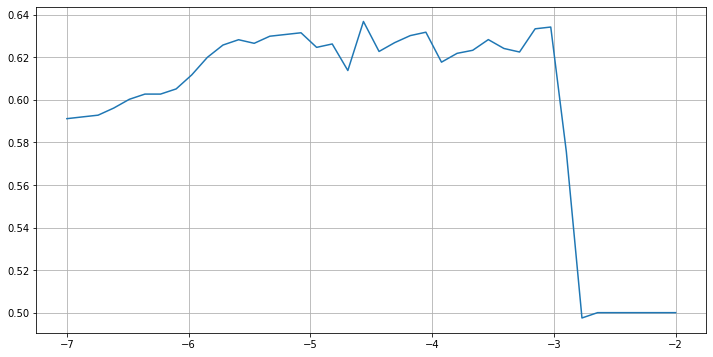

0.010419225599314 -4.564102564102564


In [26]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [9]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

-4.3 0.013568559012200934


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


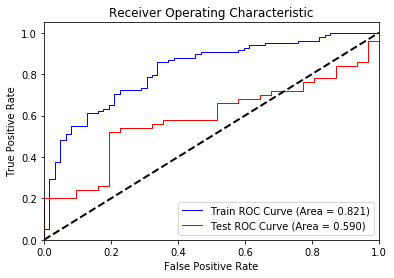

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

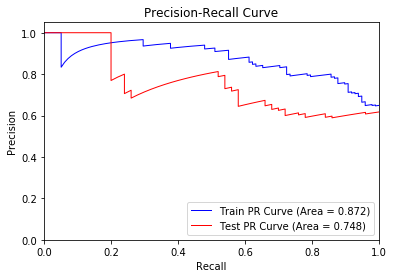

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 284


,HIF,Beta,Cluster
318,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,1.592433,11
229,COUNT PROP [MACROPHAGE CELLS] IN [[ESI_0080] OVER [TUMOR]]_HE,0.683636,12
581,TOTAL [CANCER CELLS] IN [STROMA] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,0.504272,1
203,COUNT PROP [FIBROBLAST CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.456315,15
187,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF PLASMA IN TUMOR_HE,0.321379,11
...,...,...,...
579,TOTAL [CANCER CELLS] IN [ESI_0080] SELECTED BY [PLASMA_RADIUS_80]_HE,-0.181030,1
79,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF LYMPHOCYTE IN TUMOR_HE,-0.280295,6
30,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN STROMA_HE,-0.327014,1
244,COUNT PROP [PLASMA CELLS] IN [[STROMA] OVER [TUMOR]]_HE,-0.378225,15


### Outer Loop 2

In [14]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(161, 607) (161,)
(80, 607) (80,)


In [23]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [24]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.0024787521766663594, 0.0027489074857791197, 0.003048506597999281, 0.0033807585472128547, 0.0037492221148722133, 0.004157843948434413, 0.004611000834268225, 0.005113546577819013, 0.0056708639931691346, 0.006288922558858995, 0.006974342357525473, 0.007734464984221253, 0.008577432182920498, 0.009512273053493954, 0.010549000763235271, 0.011698719798824914, 0.01297374490751713, 0.014387733001540358, 0.01595582943855103, 0.01769483024496462, 0.019623362019752715, 0.021762081445672734, 0.02413389654491333, 0.026764212049045312, 0.0296812015114584, 0.03291610907690537, 0.03650358414043513, 0.04048205248027766, 0.044894127839919556, 0.04978706836786395]
0.0024787521766663594
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7517006802721089, 0.8016975308641977, 0.7588734567901235, 0.7457561728395062, 0.7106481481481481]
0.0027489074857791197
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7120181405895691, 0.7978395061728395, 0.73070987654321, 0.7492283950617284, 0.7449845679012346]
0.003048506597999281
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7316704459561603, 0.8074845679012346, 0.7260802469135802, 0.7515432098765432, 0.748070987654321]
0.0033807585472128547
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.761148904006047, 0.8190586419753088, 0.7256944444444443, 0.7766203703703705, 0.7484567901234568]
0.0037492221148722133
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7585034013605442, 0.8094135802469136, 0.7318672839506173, 0.78125, 0.7523148148148149]
0.004157843948434413
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.764172335600907, 0.8364197530864198, 0.775462962962963, 0.7978395061728396, 0.7527006172839505]
0.004611000834268225
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7683295540438397, 0.7839506172839507, 0.7727623456790124, 0.8009259259259259, 0.679783950617284]
0.005113546577819013
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.781557067271353, 0.8375771604938271, 0.748070987654321, 0.7260802469135803, 0.6481481481481481]
0.0056708639931691346
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7403628117913832, 0.8094135802469136, 0.7696759259259259, 0.787037037037037, 0.6929012345679012]
0.006288922558858995
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7891156462585034, 0.7881944444444444, 0.7924382716049383, 0.7881944444444445, 0.7978395061728396]
0.006974342357525473
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.6938775510204082, 0.7669753086419754, 0.7974537037037038, 0.7993827160493827, 0.7881944444444444]
0.007734464984221253
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7547241118669691, 0.804783950617284, 0.7800925925925927, 0.8101851851851852, 0.7824074074074074]
0.008577432182920498
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.782312925170068, 0.8206018518518519, 0.7527006172839507, 0.8294753086419753, 0.7665895061728395]
0.009512273053493954
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8027210884353742, 0.8063271604938271, 0.695601851851852, 0.6828703703703705, 0.7893518518518519]
0.010549000763235271
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8008314436885865, 0.8248456790123456, 0.7920524691358025, 0.8148148148148148, 0.6971450617283951]
0.011698719798824914
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7932728647014362, 0.8032407407407407, 0.8078703703703705, 0.8233024691358024, 0.7932098765432098]
0.01297374490751713
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8129251700680272, 0.8209876543209877, 0.8121141975308642, 0.7349537037037037, 0.6840277777777777]
0.014387733001540358
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7932728647014361, 0.7916666666666666, 0.7098765432098766, 0.648533950617284, 0.7033179012345679]
0.01595582943855103
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8102796674225246, 0.8186728395061728, 0.7021604938271606, 0.8186728395061729, 0.7766203703703703]
0.01769483024496462
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8117913832199546, 0.7885802469135802, 0.8148148148148148, 0.8213734567901235, 0.7129629629629629]
0.019623362019752715
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8219954648526077, 0.7399691358024691, 0.693287037037037, 0.6739969135802469, 0.7299382716049384]
0.021762081445672734
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8072562358276645, 0.7851080246913581, 0.6994598765432098, 0.6751543209876544, 0.6986882716049383]
0.02413389654491333
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8057445200302343, 0.8171296296296295, 0.8128858024691358, 0.8321759259259259, 0.753858024691358]
0.026764212049045312
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7985638699924414, 0.8387345679012346, 0.8128858024691358, 0.8314043209876543, 0.7160493827160495]
0.0296812015114584
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7921390778533636, 0.8275462962962964, 0.6732253086419753, 0.8298611111111112, 0.7303240740740742]
0.03291610907690537
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7910052910052909, 0.8206018518518519, 0.6732253086419754, 0.8279320987654321, 0.7592592592592592]
0.03650358414043513
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7864701436130007, 0.8383487654320987, 0.7824074074074073, 0.6450617283950618, 0.7268518518518519]
0.04048205248027766
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7664399092970522, 0.8290895061728395, 0.7681327160493827, 0.6412037037037037, 0.8132716049382717]
0.044894127839919556
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7819349962207105, 0.808641975308642, 0.7511574074074074, 0.7681327160493827, 0.7916666666666667]
0.04978706836786395
1
0.5294117647058824 0.5242718446601942
(408, 607) (408,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.5281173594132029 0.5294117647058824
(409, 607) (409,) (102, 607) (102,)
[0.8080120937263796, 0.8016975308641975, 0.7619598765432098, 0.7662037037037037, 0.7955246913580247]


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.



[0.753735197782817, 0.7469560972537164, 0.7529698916603678, 0.7661958301839256, 0.766669816074578, 0.7853190350214161, 0.7611504787100025, 0.7482867220962459, 0.7598781179138321, 0.791156462585034, 0.769176744771983, 0.7864386495338876, 0.790336041824137, 0.7553744646006552, 0.785937893675989, 0.8041792642983119, 0.7730017006802721, 0.7293335852859663, 0.7852812421264802, 0.7899045729402872, 0.7318373645754598, 0.733133345930965, 0.8043587805492567, 0.7995275888133031, 0.7706191735953641, 0.7744047619047618, 0.7558279793398841, 0.76362748803225, 0.780306752330562, 0.786679579239103]


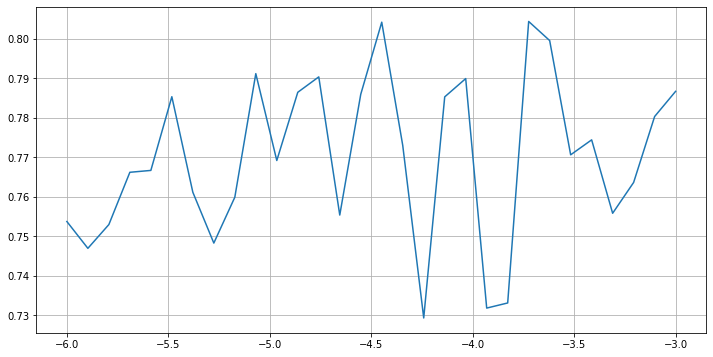

0.02413389654491333 -3.724137931034482


In [25]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [15]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.7
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

-3.7 0.024723526470339388


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


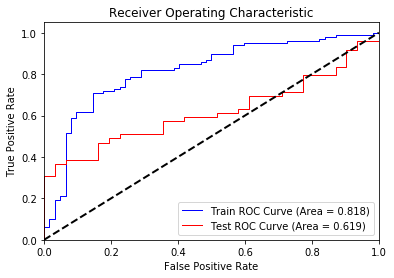

In [16]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

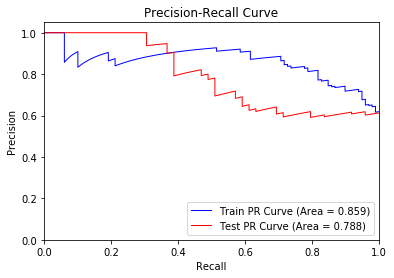

In [17]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 49


,HIF,Beta,Cluster
217,COUNT PROP [LYMPHOCYTE CELLS] IN [[ESI_0080] OVER [TUMOR]]_HE,0.236712,12
520,REGION PROPERTIES: PERIMETER^2 / AREA OF TUMOR_HE,0.167285,22
229,COUNT PROP [MACROPHAGE CELLS] IN [[ESI_0080] OVER [TUMOR]]_HE,0.024225,12
189,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,0.024047,13
228,COUNT PROP [MACROPHAGE CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,0.023810,12
340,DENSITY RATIO [CANCER CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.016970,13
176,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN EPITHE...,0.016120,9
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.011560,22
518,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF TUMOR_HE,0.011314,22
343,DENSITY RATIO [CANCER CELLS] IN [[TUMOR] OVER [STROMA]]_HE,0.011167,13


### Outer Loop 3

In [20]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(161, 607) (161,)
(80, 607) (80,)


In [36]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [37]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.0024787521766663594, 0.0027489074857791197, 0.003048506597999281, 0.0033807585472128547, 0.0037492221148722133, 0.004157843948434413, 0.004611000834268225, 0.005113546577819013, 0.0056708639931691346, 0.006288922558858995, 0.006974342357525473, 0.007734464984221253, 0.008577432182920498, 0.009512273053493954, 0.010549000763235271, 0.011698719798824914, 0.01297374490751713, 0.014387733001540358, 0.01595582943855103, 0.01769483024496462, 0.019623362019752715, 0.021762081445672734, 0.02413389654491333, 0.026764212049045312, 0.0296812015114584, 0.03291610907690537, 0.03650358414043513, 0.04048205248027766, 0.044894127839919556, 0.04978706836786395]
0.0024787521766663594
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8133030990173847, 0.7996976568405141, 0.7542438271604939, 0.7310956790123456, 0.7496141975308642]
0.0027489074857791197
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8333333333333333, 0.8102796674225246, 0.6867283950617284, 0.7982253086419753, 0.7395833333333334]
0.003048506597999281
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8114134542705971, 0.7947845804988662, 0.7411265432098765, 0.6994598765432098, 0.7453703703703703]
0.0033807585472128547
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.817838246409675, 0.8219954648526078, 0.7584876543209876, 0.6952160493827161, 0.8009259259259259]
0.0037492221148722133
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8235071806500377, 0.799697656840514, 0.7627314814814814, 0.7569444444444444, 0.7623456790123457]
0.004157843948434413
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8238851095993953, 0.8189720332577475, 0.7561728395061729, 0.7642746913580247, 0.8125]
0.004611000834268225
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.817838246409675, 0.8114134542705972, 0.7596450617283951, 0.7098765432098766, 0.8082561728395061]
0.005113546577819013
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.819349962207105, 0.8049886621315193, 0.7527006172839507, 0.78125, 0.8109567901234568]
0.0056708639931691346
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.846182917611489, 0.8148148148148149, 0.7885802469135803, 0.7816358024691358, 0.7777777777777778]
0.006288922558858995
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8238851095993953, 0.8178382464096751, 0.7800925925925927, 0.7434413580246914, 0.8101851851851852]
0.006974342357525473
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8397581254724111, 0.7872260015117158, 0.7700617283950617, 0.7210648148148148, 0.8094135802469136]
0.007734464984221253
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7876039304610734, 0.8197278911564626, 0.7916666666666666, 0.8043981481481481, 0.8016975308641975]
0.008577432182920498
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8284202569916855, 0.8235071806500378, 0.7820216049382716, 0.806712962962963, 0.8271604938271605]
0.009512273053493954
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8061224489795918, 0.825018896447468, 0.8036265432098766, 0.7573302469135802, 0.8109567901234568]
0.010549000763235271
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8386243386243387, 0.8167044595616024, 0.7708333333333335, 0.7206790123456791, 0.8194444444444445]
0.011698719798824914
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8488284202569917, 0.7849584278155707, 0.7989969135802469, 0.7337962962962963, 0.7997685185185186]
0.01297374490751713
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8303099017384733, 0.808390022675737, 0.7727623456790125, 0.6847993827160493, 0.8032407407407408]
0.014387733001540358
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7758881330309901, 0.8212396069538926, 0.8055555555555556, 0.8159722222222222, 0.8248456790123457]
0.01595582943855103
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7687074829931974, 0.7694633408919123, 0.8128858024691359, 0.8101851851851852, 0.8229166666666666]
0.01769483024496462
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.755479969765684, 0.7139077853363568, 0.7993827160493827, 0.7457561728395062, 0.8271604938271605]
0.019623362019752715
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.745275888133031, 0.8008314436885865, 0.7538580246913581, 0.6597222222222222, 0.6087962962962963]
0.021762081445672734
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8223733938019652, 0.7864701436130007, 0.7561728395061729, 0.6334876543209875, 0.7804783950617284]
0.02413389654491333
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.7724867724867726, 0.7328042328042328, 0.7955246913580247, 0.7939814814814815, 0.7615740740740741]
0.026764212049045312
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8125472411186696, 0.7944066515495086, 0.7426697530864197, 0.7700617283950617, 0.816743827160494]
0.0296812015114584
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)
4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8325774754346182, 0.7966742252456539, 0.7905092592592592, 0.7268518518518519, 0.8152006172839507]
0.03291610907690537
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)
4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it 

5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8219954648526077, 0.7709750566893425, 0.7874228395061729, 0.7939814814814815, 0.8128858024691359]
0.03650358414043513
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8299319727891157, 0.7052154195011338, 0.7939814814814815, 0.7758487654320988, 0.8032407407407408]
0.04048205248027766
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8242630385487528, 0.7600151171579743, 0.7881944444444444, 0.7843364197530864, 0.8047839506172839]
0.044894127839919556
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




[0.8151927437641724, 0.780045351473923, 0.7908950617283951, 0.7812499999999999, 0.7662037037037036]
0.04978706836786395
1
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




2
0.5281173594132029 0.5242718446601942
(409, 607) (409,) (103, 607) (103,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




3
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




4
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning:


The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`




5
0.526829268292683 0.5294117647058824
(410, 607) (410,) (102, 607) (102,)
[0.8212396069538928, 0.7758881330309902, 0.7878086419753086, 0.7750771604938271, 0.7993827160493827]


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning:

The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.



[0.7695908919123207, 0.7736300075585791, 0.7584309649785841, 0.7788926681783825, 0.7810452884857646, 0.7951609347442681, 0.7814058956916099, 0.7938492063492063, 0.8017983119173596, 0.7950884983623079, 0.7855048500881834, 0.8010188334593098, 0.8135644998740237, 0.8006109851347947, 0.7932571176618797, 0.7932697152935249, 0.7799004787100026, 0.8087002393550012, 0.7968316956412195, 0.7683374275636181, 0.7136967750062988, 0.7557964852607709, 0.7712742504409171, 0.7872858402620307, 0.7923626858150666, 0.7974521289997482, 0.7816436759889142, 0.7923185941043084, 0.7867173721340388, 0.7918792517006803]


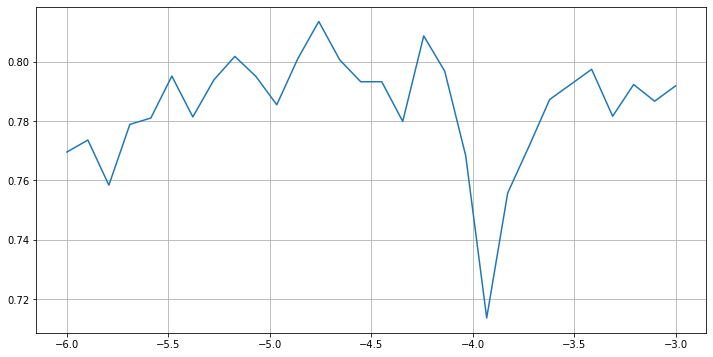

0.008577432182920498 -4.758620689655173


In [38]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [21]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

-3.6 0.02732372244729256


/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:403: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest 
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument 
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/group_lasso/_fista.py:55: RuntimeWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise,try to increase the number of iterations or decreasing the tolerance.
  RuntimeWarning,


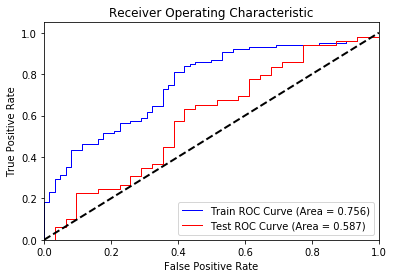

In [22]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

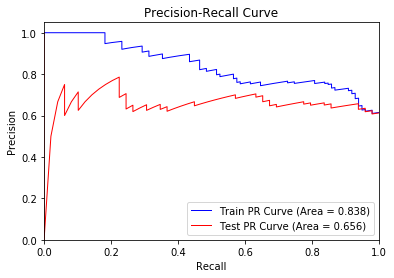

In [23]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 86


,HIF,Beta,Cluster
516,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.397372,23
319,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.223910,10
372,DENSITY RATIO [MACROPHAGE CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,0.176635,4
315,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.146036,10
364,DENSITY RATIO [LYMPHOCYTE CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.138523,4
...,...,...,...
110,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF CANCER IN STROMA_HE,-0.074788,13
170,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF CANCER IN STROMA_HE,-0.086408,13
297,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,-0.118012,10
90,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF CANCER IN STROMA_HE,-0.124545,13


## Compute Ensemble Model

In [25]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
318,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,1.592433,0.000000,0.000000,11,0.530811
229,COUNT PROP [MACROPHAGE CELLS] IN [[ESI_0080] OVER [TUMOR]]_HE,0.683636,0.024225,0.000000,12,0.235954
581,TOTAL [CANCER CELLS] IN [STROMA] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,0.504272,0.000000,0.000000,1,0.168091
319,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.269422,0.000000,0.223910,10,0.164444
203,COUNT PROP [FIBROBLAST CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.456315,0.000000,0.000000,15,0.152105
...,...,...,...,...,...,...
30,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN STROMA_HE,-0.327014,0.000000,0.000000,1,-0.109005
244,COUNT PROP [PLASMA CELLS] IN [[STROMA] OVER [TUMOR]]_HE,-0.378225,0.000000,0.000000,15,-0.126075
170,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF CANCER IN STROMA_HE,0.000000,-0.418103,-0.086408,13,-0.168170
415,DENSITY [PLASMA CELLS] IN [TUMOR]_HE,-0.560921,0.000000,0.000000,11,-0.186974


## Compute Final Train / Test Metrics

In [26]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.8214285714285715, 0.8181818181818181, 0.7559465623981754]
0.7985189840028549 0.030132415133056412


In [27]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.5903225806451613, 0.618828176431863, 0.587228439763002]
0.5987930656133421 0.014223165987980629


In [28]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.8718141769424502, 0.8593090760433819, 0.8382395959386856]
0.8564542829748393 0.013854614273296291


In [29]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7480280146123678, 0.787831883164831, 0.6555839414683577]
0.7304812797485187 0.055397325140149174


## Evaluate Hold-Out Set

In [30]:
holdout_df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/stad.CTLA4.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.CTLA4_data
0,8.061936,8.205972,0.484000,9.612336,17.674272,5960.750045,6015.158862,5035.768153,5661.540493,4538.992026,...,1037.836240,65.492954,104.679860,211.499057,144.899886,46.887001,148.062899,304.816644,187.164710,1
1,20.967920,26.908096,4.562176,9.960640,30.928560,7276.155102,7109.897710,7162.881625,7587.011393,5890.079106,...,231.824566,53.224163,107.774255,344.957754,147.177883,13.449117,117.696919,322.067658,112.840688,0
2,5.561952,15.443124,0.145216,19.614880,25.176832,5809.600670,6343.137744,6323.425989,6622.191015,4994.047755,...,2872.521849,52.319761,109.369063,191.283352,160.584143,82.884570,208.636543,328.118245,273.942329,1
3,8.840400,14.701344,0.596208,12.003328,20.843728,6607.093302,6781.979545,6280.097632,7077.515147,5948.476450,...,2848.290862,82.349215,152.230980,272.840999,192.048179,648.047600,725.375857,906.998459,797.170257,1
4,2.824304,7.961844,0.021408,13.157760,15.982064,5606.511459,5305.557452,5696.184195,6130.182737,5449.218610,...,742.394724,12.038364,27.882988,38.456394,33.787876,45.674970,133.888582,150.785544,132.210708,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,105.665040,183.396776,4.844480,135.345968,241.011008,7097.986120,6935.958813,6512.172073,7193.044989,6414.969935,...,1027.343116,55.742183,69.630450,108.477557,85.357097,73.382833,135.869346,182.835147,134.848612,1
83,39.131056,63.708776,16.374176,61.549024,100.680080,5877.658131,6408.470450,5392.543322,5960.688470,4955.038907,...,777.303713,42.242663,76.425891,198.524675,137.782966,17.888605,36.164562,131.894862,87.584356,0
84,76.872160,128.647732,1.674992,96.225184,173.097344,6079.464478,6367.159464,5947.752867,6346.569587,5185.458907,...,1333.134262,33.328061,96.861404,196.050547,123.785839,47.403377,116.978355,210.485438,138.061044,0
85,74.135744,102.547360,12.267408,92.817552,166.953296,6521.817916,6462.533081,5787.717947,6698.129215,5066.682916,...,1495.639835,21.163880,74.502162,184.695670,112.079249,20.745728,97.125855,174.708335,106.341117,1


In [31]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-1.190406,-1.399631,-0.649203,-1.396942,-1.528957,-0.581451,-0.529162,-1.127052,-1.349624,-0.807502,...,-0.184949,-0.293690,0.110926,0.079609,0.147491,0.164093,-0.252414,0.070596,0.230688,0.179339
1,-0.860924,-0.999179,-0.395768,-1.388290,-1.331948,1.244579,1.198157,2.152542,1.663461,0.994490,...,-1.421042,-1.424925,-0.109991,0.120813,1.272797,0.190473,-0.596143,-0.149277,0.307995,-0.349569
2,-1.254229,-1.244668,-0.670256,-1.148471,-1.417441,-0.791275,-0.011665,0.858265,0.153656,-0.200578,...,1.626711,2.281284,-0.126276,0.142049,-0.022966,0.345720,0.117627,0.509195,0.335110,0.796869
3,-1.170532,-1.260551,-0.642229,-1.337548,-1.481847,0.315795,0.680756,0.791461,0.866173,1.072377,...,1.888213,2.247276,0.414448,0.712786,0.664718,0.710080,5.927290,4.250781,2.929252,4.520285
4,-1.324120,-1.404858,-0.677950,-1.308871,-1.554110,-1.073201,-1.648797,-0.108820,-0.616266,0.406499,...,-1.149112,-0.708342,-0.851601,-0.942996,-1.311583,-1.122607,-0.264873,-0.032037,-0.459573,-0.211727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1.301344,2.351575,-0.378224,1.726390,1.790676,0.997246,0.923710,1.149275,1.046961,1.694556,...,-0.391147,-0.308418,-0.064651,-0.387099,-0.721173,-0.525424,0.019953,-0.017695,-0.315949,-0.192955
83,-0.397230,-0.211198,0.338279,-0.106790,-0.295175,-0.696798,0.091419,-0.576975,-0.881500,-0.252605,...,-0.789110,-0.659347,-0.307729,-0.296613,0.038092,0.081678,-0.550507,-0.739633,-0.544228,-0.529299
84,0.566279,1.179282,-0.575189,0.754596,0.781221,-0.416653,0.026237,0.279050,-0.277652,0.054714,...,0.185311,0.120759,-0.468249,-0.024499,0.017231,-0.080412,-0.247106,-0.154480,-0.192039,-0.170095
85,0.496419,0.620418,0.083068,0.669947,0.689897,0.197417,0.176721,0.032308,0.272489,-0.103702,...,0.526770,0.348835,-0.687283,-0.322228,-0.078512,-0.215976,-0.521136,-0.298227,-0.352368,-0.395821


In [32]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

57


In [33]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [34]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

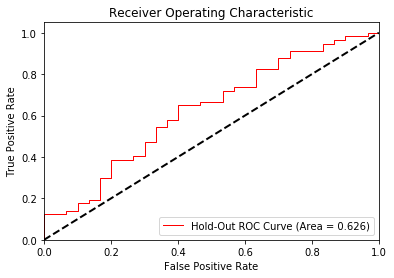

In [35]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.626


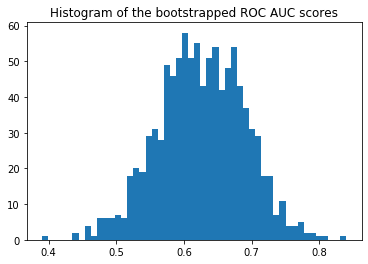

Confidence interval for the score: [0.498 - 0.746]


In [36]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

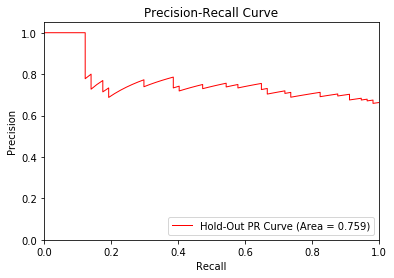

In [37]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.759


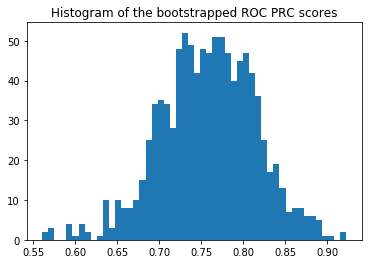

Confidence interval for the score: [0.638 - 0.867]


In [38]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))